## Uncertainty in Explanations via Input Perturbation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from xplique.attributions import Lime, Saliency
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

In [2]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [3]:
# Build and train a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)

Epoch 1/2
704/704 [==============================] - 18s 26ms/step - loss: 0.2165 - accuracy: 0.9360 - val_loss: 0.0733 - val_accuracy: 0.9780
Epoch 2/2
704/704 [==============================] - 19s 26ms/step - loss: 0.0611 - accuracy: 0.9807 - val_loss: 0.0585 - val_accuracy: 0.9823


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [4]:
model(x_test)

<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[9.11252229e-08, 2.33818440e-07, 2.98176947e-05, ...,
        9.99772727e-01, 1.50857818e-06, 2.49414788e-05],
       [1.31897605e-05, 8.43362126e-04, 9.99136269e-01, ...,
        5.54951152e-09, 4.90966795e-06, 4.25192798e-11],
       [8.22710444e-06, 9.99506235e-01, 2.83842019e-05, ...,
        1.58670024e-04, 2.05778761e-05, 6.12699841e-06],
       ...,
       [1.22070809e-09, 5.00141778e-06, 2.57397131e-10, ...,
        7.92687501e-07, 2.29404986e-06, 2.65834533e-05],
       [1.17590916e-05, 6.91008717e-09, 1.01261914e-08, ...,
        2.37504487e-08, 3.76583135e-04, 6.90670788e-07],
       [1.45348249e-05, 1.98838235e-09, 1.62588531e-05, ...,
        3.34690109e-10, 1.43065899e-05, 1.60272577e-08]], dtype=float32)>

In [29]:
# Explain sample prediction
sample_index = 0
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
#sample_image = gray2rgb(sample_image.squeeze())  # LIME expects RGB images
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)

model.layers[-1].activation = tf.keras.activations.linear
explainer = Saliency(model)
#explainer = Lime(model)
explanation = explainer.explain(sample_image, sample_label)

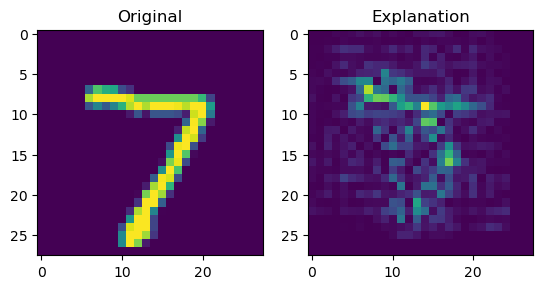

In [30]:
# Display explanation
plt.subplot(121)
plt.imshow(sample_image.squeeze()) # shape (1, 28, 28, 1)
plt.title("Original")
plt.subplot(122)
plt.imshow(explanation.squeeze()) # shape (1, 28, 28)
plt.title("Explanation")
#plt.colorbar()
plt.show()

In [37]:
# Compute gradient of explanation w.r.t input via FEM
h=1e-4
sample_image = sample_image.squeeze()
gradients = np.zeros_like(sample_image)

for i in range(sample_image.shape[0]):
    for j in range(sample_image.shape[1]):
        # Perturb pixel (i, j)
        perturbed_image = np.copy(sample_image)
        perturbed_image[i, j] += h
        #perturbed_image = np.clip(perturbed_image, 0, 1)

        # Compute explanation for perturbed image
        perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)

        # Compute finite difference gradient
        gradients[i, j] = (perturbed_explanation[0, i, j] - explanation[0, i, j]) / h

$$Var(e(\widetilde{x},\hat{y})) \approx \nabla_x e(x,\hat{y})^T \cdot \Sigma_{\Delta x} \cdot \nabla_x e(x,\hat{y})$$

Wenn die Störung im Input normal verteilt ist, dann ist die Kovarianzmatrix diagonal und alle EWe sind gleich:

$$\Delta x \sim \mathcal{N}(0, \sigma^2 I), \Sigma_{\Delta x} = \sigma^2 I$$

(Sonst diagonalisiere...)

Es heißt, die Varianz in der Erklärung wird:

$$Var(e(\widetilde{x},\hat{y})) \approx \sigma^2 ||\nabla_x e(x,\hat{y})||_2^2$$

In [39]:
# Compute variance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * np.sum(gradients ** 2)

print("Variance of Explanation (Analytical):", variance_explanation)

Variance of Explanation (Analytical): 4.1680738050708984e-07


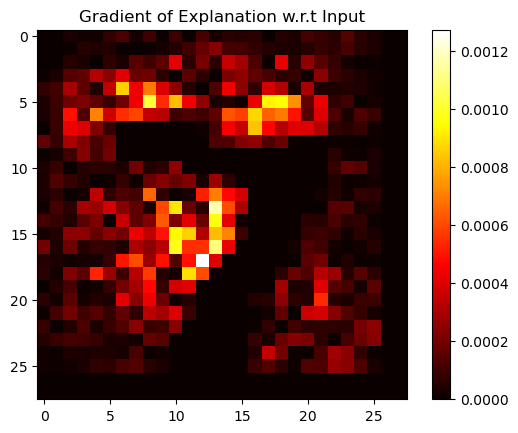

In [41]:
# Visualize the gradient for insight
plt.imshow(np.abs(gradients.squeeze()), cmap='hot')
plt.title("Gradient of Explanation w.r.t Input")
plt.colorbar()
plt.show()